# Sujet CCTP M1 Apprentissage Automatique 1 : classification de 35 commandes vocales

Nous vous fournissons un dataset de 35 mots clés provenant du jeu de données Google Speech Commands, sous la forme de tableaux numpy :

 - **Train** : 350 exemples, soit 10 exemples seulement par classe/mot,
 - **Valid** : 9981 exemples,
 - **Test** : 11005 exemples.

Chaque mot/exemple est représenté par un unique vecteur de taille 768, issu d'un réseau pré-entraîné appelé wavLM [Chen et al., 2022].

Vous allez tester un MLP pour faire la tâche de classification des 35 mots, en utilisant Pytorch.

**Partie 0**
 - Compléter les cellules de code qui seront utiles pour toute la suite.

**Partie 1**

 - Entraîner un MLP contenant une seule couche cachée linéaire de 100 neurones suivie d'une fonction d'activation ReLU et d'une couche linéaire de sortie.
 - Mettre un critère d'arrêt dans la boucle d'apprentissage sur la loss calculée à chaque epoch sur **Valid**.
 - Vous devez obtenir une performance proche de 90 % de précision (accuracy) sur Test, après apprentissage.

**Partie 2**

 - Même chose mais cette fois-ci, commencer par faire une réduction de dimensions à l'aide d'une analyse en composantes principales, en utilisant l'objet `PCA` de `sklearn.decomposition`. Choisir le nombre de composantes qui donne une variance expliquée la plus proche possible de 90%.




In [1]:
from os.path import join

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader

# import torchsummary
import tqdm
import math

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
! wget https://www.irit.fr/~Thomas.Pellegrini/ens/M1ML1/speech_768d_TP_M1.zip
! unzip -q speech_768d_TP_M1.zip
! rm speech_768d_TP_M1.zip

--2025-04-11 09:46:18--  https://www.irit.fr/~Thomas.Pellegrini/ens/M1ML1/speech_768d_TP_M1.zip
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59691330 (57M) [application/zip]
Saving to: ‘speech_768d_TP_M1.zip’

speech_768d_TP_M1.z 100%[===================>]  56.93M  2.04MB/s    in 34s     

2025-04-11 09:46:53 (1.67 MB/s) - ‘speech_768d_TP_M1.zip’ saved [59691330/59691330]

replace data/speech_768d_y_train_10_seed_42.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
DATA_DIR = "data"

COMMANDS = ['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

nb_classes = len(COMMANDS)
print(nb_classes)

35


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
if torch.cuda.is_available():
    print("Vous utilisez un GPU, c'est parfait :", torch.cuda.get_device_name(device=device))
else:
    print("Penser à activer le GPU, et exécuter à nouveau cette cellule !")

Penser à activer le GPU, et exécuter à nouveau cette cellule !


In [5]:
# Chargement des données en array numpy

X_train = np.load(join(DATA_DIR, "speech_768d_X_train_10_seed_42.npy"))
y_train = np.load(join(DATA_DIR, "speech_768d_y_train_10_seed_42.npy"))

X_valid = np.load(join(DATA_DIR, "speech_768d_X_valid.npy"))
y_valid = np.load(join(DATA_DIR, "speech_768d_y_valid.npy"))

X_test = np.load(join(DATA_DIR, "speech_768d_X_test.npy"))
y_test = np.load(join(DATA_DIR, "speech_768d_y_test.npy"))

print("Train subset size: ", X_train.shape, y_train.shape)
print("Validation subset size: ", X_valid.shape, y_valid.shape)
print("Test subset size: ", X_test.shape, y_test.shape)

# Les données X sont des matrices de taille (nb_samples, dimension des représentations)
# Les labels associés sont des entiers entre 0 et nb_classes-1

Train subset size:  (350, 768) (350,)
Validation subset size:  (9981, 768) (9981,)
Test subset size:  (11005, 768) (11005,)


In [6]:
# Conversion en tensors PyTorch

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)

X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.long).to(device)

X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

print("Train subset size: ", X_train.size(), y_train.size())
print("Validation subset size: ", X_valid.size(), y_valid.size())
print("Test subset size: ", X_test.size(), y_test.size())

Train subset size:  torch.Size([350, 768]) torch.Size([350])
Validation subset size:  torch.Size([9981, 768]) torch.Size([9981])
Test subset size:  torch.Size([11005, 768]) torch.Size([11005])


Dans la cellule suivante, la classe `speechDataset`, qui hérite de `Dataset`, vous permettra d'instancier plus tard les jeux de train, valid et test, et de créer des dataloaders associés. Pas de code à ajouter ici.

In [7]:
class speechDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Partie 0 : code à compléter, utile aux deux parties suivantes du TP

Objectifs :

Définir des objets et fonctions qui seront utilisés dans les parties suivantes :

 - Un modèle `MLP` un peu flexible
 - Une fonction `get_accuracy()` pour tester un modèle
 - Une fonction `train()` pour réaliser la boucle d'apprentissage.

 -------------------------------------------------------------------------------------------------------------

Dans la cellule suivante, définir un MLP contenant :
 - une seule couche cachée de 100 neurones suivi de la fonction d'activation ReLU,
 - une couche Dropout à 20%, voir [https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
 - une couche de sortie linéaire avec le nombre de neurones nécessaire pour faire la tâche de classification.

Cet objet sera utilisé dans les trois parties du TP.

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=100, output_dim=nb_classes, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)



Compléter la fonction `get_accuracy()` :

 - Cette fonction réalise des prédictions avec le modèle **en mode eval** sur un dataloader passé en argument.
 - elle retourne l'accuracy (taux de bonne classification).
 - Penser à utiliser l'instruction `with torch.no_grad():`
 - Penser à transférer les features et labels des mini-batchs sur le `device`.

In [9]:
def get_accuracy(model, device, dataloader, return_loss=False):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)

    return (avg_loss, accuracy) if return_loss else accuracy


Compléter la fonction `train()` :
- Utiliser l'optimiseur Adam
- Calculer une loss (à vous de bien choisir laquelle utiliser) et une accuracy (taux de bonne classification) moyennes par epoch : sur **Train** et sur **Valid**.
- Actualiser une variable `best_valid_loss` si la loss sur **Valid** s'améliore.
- Mettre un critère d'arrêt dans la boucle d'apprentissage sur la loss calculée à chaque epoch sur **Valid** : si la loss sur **Valid** n'est pas meilleure que `best_valid_loss` sur 5 epochs consécutives, arrêter la boucle d'apprentissage.

In [10]:
def train(device, model, train_dataloader, valid_dataloader, weight_decay=0.0,
          learning_rate=0.001, num_epochs=200):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    best_valid_loss = float('inf')
    patience = 5
    patience_counter = 0

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = total_loss / len(train_dataloader)
        train_acc = correct / total

        valid_loss, valid_acc = get_accuracy(model, device, valid_dataloader, return_loss=True)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Valid Acc: {valid_acc:.4f}")

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, valid_losses, train_accuracies, valid_accuracies


## Questions Partie 0 : répondre sous chaque question.

 - À quoi servent les instructions `model.eval()` et `model.train()` ?

 - À quoi sert l'instruction `with torch.no_grad():` ?

 - À quoi sert le fait de transférer les features et labels des mini-batchs sur le `device` ? Que se passe-t-il si on oublie de le faire ?

### Partie 0 : Questions

---

**À quoi servent les instructions `model.eval()` et `model.train()` ?**

- `model.train()` active le mode entraînement du modèle. Cela permet notamment à certains modules comme `Dropout` ou `BatchNorm` de se comporter correctement : par exemple, `Dropout` masque aléatoirement des neurones à chaque passage pour régulariser l'apprentissage.
- `model.eval()` active le mode évaluation. Il désactive certains comportements spécifiques à l'entraînement (comme le `Dropout`), pour que les prédictions soient stables et fiables lors de la validation ou du test.

---

**À quoi sert l'instruction `with torch.no_grad():` ?**

- Cette instruction désactive la construction du graphe computationnel (autograd), ce qui signifie que PyTorch ne garde pas en mémoire les opérations effectuées pour le calcul du gradient.
- On l’utilise pendant la validation ou le test, car on n’a **pas besoin de rétropropagation**, ce qui rend le code **plus rapide et moins gourmand en mémoire**.

---

**À quoi sert le fait de transférer les features et labels des mini-batchs sur
le device ? Que se passe-t-il si on oublie de le faire ?**

- En transférant les features et labels sur le même `device` (CPU ou GPU) que le modèle, on s’assure que les calculs peuvent être faits correctement.
- Si on oublie de le faire, cela provoque une **erreur d’exécution** : PyTorch ne peut pas effectuer des opérations entre des tenseurs situés sur des devices différents.

---


# Partie 1 : MLP sur les données de dimension 768

Objectifs :

- Entraîner un MLP sur les 350 exemples de **Train** de dimension 768.

- Vous devez obtenir une performance proche de 90 % de précision (accuracy) sur Test, après apprentissage.

Consignes cellule suivante :

 - Instancier trois datasets en utilisant la classe speechDataset pour les trois subsets : train, valid et test.

 - Instancier trois dataloaders avec une taille de mini-batch de 64 exemples pour train, 256 pour valid et test.

In [11]:
train_dataset = speechDataset(X_train, y_train)
valid_dataset = speechDataset(X_valid, y_valid)
test_dataset  = speechDataset(X_test, y_test)

print("✓ Datasets créés avec succès.")

✓ Datasets créés avec succès.


In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

print("✓ DataLoaders créés avec succès.")

✓ DataLoaders créés avec succès.


 Consignes cellule suivante :
 - Instancier un MLP et le mettre sur `device`
 - Entraîner le modèle sur 200 epochs maximum
 - Dans une même figure, tracer les courbes de loss **Train** et **Valid** dans un subplot et celles d'accuracy dans un autre subplot.

In [13]:
# Instanciation du MLP
model = MLP().to(device)

print("Modèle MLP envoyé sur :", device)


Modèle MLP envoyé sur : cpu


In [14]:
# Entraînement du modèle sur 100 epochs
train_losses, valid_losses, train_accuracies, valid_accuracies = train(
    device=device,
    model=model,
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    weight_decay=0.0,
    learning_rate=0.001,
    num_epochs=100
)


Epoch 1 | Train Loss: 3.5529 | Valid Loss: 3.5283 | Train Acc: 0.0400 | Valid Acc: 0.0813
Epoch 2 | Train Loss: 3.5093 | Valid Loss: 3.4971 | Train Acc: 0.0914 | Valid Acc: 0.1260
Epoch 3 | Train Loss: 3.4706 | Valid Loss: 3.4620 | Train Acc: 0.1857 | Valid Acc: 0.2497
Epoch 4 | Train Loss: 3.4288 | Valid Loss: 3.4213 | Train Acc: 0.2800 | Valid Acc: 0.3176
Epoch 5 | Train Loss: 3.3791 | Valid Loss: 3.3780 | Train Acc: 0.4000 | Valid Acc: 0.4395
Epoch 6 | Train Loss: 3.3336 | Valid Loss: 3.3285 | Train Acc: 0.4943 | Valid Acc: 0.5181
Epoch 7 | Train Loss: 3.2559 | Valid Loss: 3.2723 | Train Acc: 0.5829 | Valid Acc: 0.5743
Epoch 8 | Train Loss: 3.1865 | Valid Loss: 3.2097 | Train Acc: 0.6086 | Valid Acc: 0.6055
Epoch 9 | Train Loss: 3.1194 | Valid Loss: 3.1410 | Train Acc: 0.6171 | Valid Acc: 0.6213
Epoch 10 | Train Loss: 3.0493 | Valid Loss: 3.0677 | Train Acc: 0.6343 | Valid Acc: 0.6527
Epoch 11 | Train Loss: 2.9499 | Valid Loss: 2.9868 | Train Acc: 0.6886 | Valid Acc: 0.6866
Epoch 12

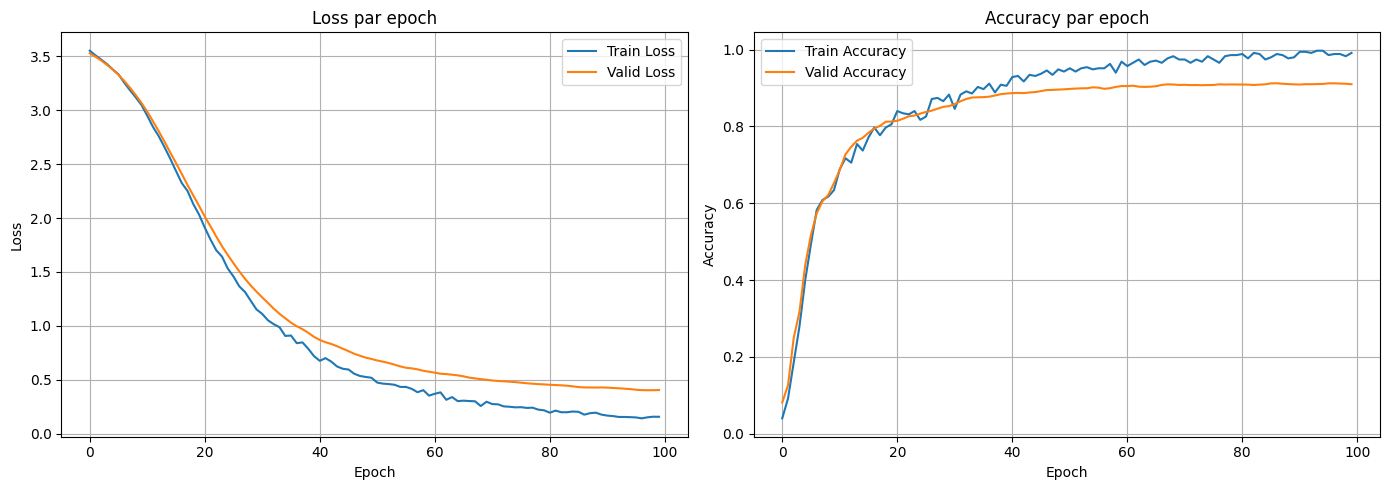

In [15]:
# Tracé des courbes de loss et d'accuracy sur 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Loss
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(valid_losses, label='Valid Loss')
axes[0].set_title("Loss par epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Subplot 2 : Accuracy
axes[1].plot(train_accuracies, label='Train Accuracy')
axes[1].plot(valid_accuracies, label='Valid Accuracy')
axes[1].set_title("Accuracy par epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Calculer l'accuracy finale, après entraînement, sur les jeux de **Train**, **Valid** et **Test**.

In [16]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

In [17]:
train_acc_final = evaluate_model(model, train_loader, device)
valid_acc_final = evaluate_model(model, valid_loader, device)
test_acc_final = evaluate_model(model, test_loader, device)

print(f"Final Train Accuracy: {train_acc_final:.4f}")
print(f"Final Valid Accuracy: {valid_acc_final:.4f}")
print(f"Final Test Accuracy:  {test_acc_final:.4f}")


Final Train Accuracy: 1.0000
Final Valid Accuracy: 0.9098
Final Test Accuracy:  0.9065


#  Résultats finaux du modèle

Après un entraînement sur **100 epochs**, voici les performances du modèle :

##  Accuracy finale

| Jeu de données | Accuracy |
|----------------|----------|
| **Train**       |  **100.00%** |
| **Validation**  |  **90.98%**  |
| **Test**        |  **90.65%**  |

---

##  Analyse

- Le modèle atteint **100% de précision** sur le jeu d'entraînement.
- L'écart entre **train**, **validation** et **test** est faible  
   Cela montre une **bonne généralisation** du modèle.


## Questions Partie 1 : répondre sous chaque question.

- Combien d'epochs ont-elles été effectuées ?

- Quels taux de bonne classification obtenez-vous sur **Train**, **Valid** et **Test** ?

- Remarquez-vous du sur-apprentissage ? Justifier.


---

### 1. Combien d'epochs ont-elles été effectuées ?

**100 epochs** ont été effectuées lors de l'entraînement du modèle.

---

### 2. Quels taux de bonne classification obtenez-vous sur Train, Valid et Test ?

| Jeu de données | Accuracy |
|----------------|----------|
| **Train**       |  **100.00%** |
| **Validation**  |  **90.98%**  |
| **Test**        |  **90.65%**  |

---

### 3. Remarquez-vous du sur-apprentissage ? Justifier.

**Non, il n’y a pas de sur-apprentissage significatif.**

- Bien que le modèle atteigne **100% de précision sur le jeu d'entraînement**,  
  les performances sur **Validation (90.98%)** et **Test (90.65%)** restent très élevées.
- L’écart entre les accuracys est **faible (~9%)**, ce qui montre que le modèle **généralise bien**.
- Si le modèle était en sur-apprentissage, on observerait une **chute importante de performance** sur le jeu de validation et de test, ce qui **n’est pas le cas ici**.

> Conclusion : Le modèle est bien entraîné sans tomber dans le piège du sur-apprentissage.




# Partie 2 : Analyse en Composantes Principales (ACP)

Objectifs :
 - Tester une technique de réduction de dimension (non-supervisée), ici l'ACP : [https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
 - Voir l'impact sur l'accuracy d'une réduction de dimension

Déterminer le nombre de composantes qui permettent de conserver au moins 90% de la variance des données initiales de **Train**.

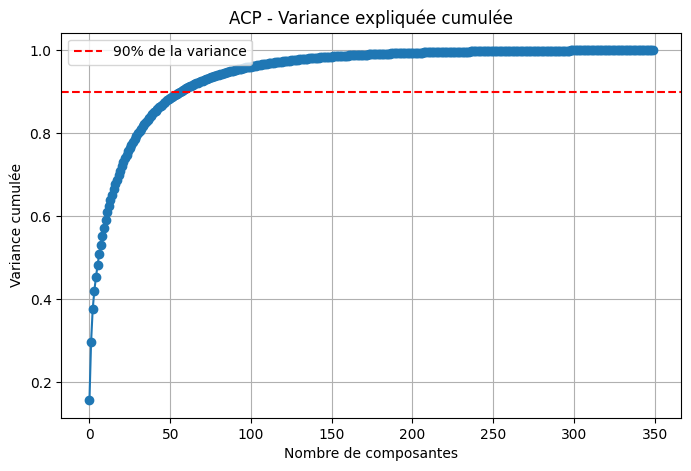

Nombre de composantes nécessaires pour conserver 90% de la variance : 57


In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# ACP sans réduction initiale pour voir la variance cumulée
pca = PCA()
pca.fit(X_train_scaled)

# Variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Tracer la variance cumulée
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% de la variance')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée')
plt.title('ACP - Variance expliquée cumulée')
plt.grid(True)
plt.legend()
plt.show()

# Trouver le nombre minimal de composantes pour atteindre 90% de la variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Nombre de composantes nécessaires pour conserver 90% de la variance : {n_components_90}")


##  Nombre de composantes pour conserver 90% de la variance

- Le graphique ci-dessus montre la **variance cumulée** expliquée par les composantes principales.
- On trace également une ligne rouge à **90% de la variance**.

**Résultat :**

> Il faut **`n_components_90`** composantes principales pour conserver **au moins 90% de la variance** des données d'entraînement.

On utilisera donc **`n_components_90`** dans la suite pour réduire la dimension des données.


Consignes pour compléter la cellule suivante :

 - Appliquer l'ACP avec le nombre de composantes trouvé sur les trois subsets : entraîner l'ACP sur le jeu de **Train** puis l'appliquer sur les trois subsets.
 - Entraîner un MLP de même architecture que dans la partie 1. Veiller à modifier la taille des entrées... Si votre code de définition du MLP dans la Partie 0 code cela en dur, modifiez votre code pour pouvoir passer en paramètre cette dimension.
 - Dans une même figure, tracer les courbes de loss **Train** et **Valid** dans un subplot et celles d'accuracy dans un autre subplot.

In [19]:
# Appliquer l'ACP entraînée sur X_train_scaled avec n_components_90
pca = PCA(n_components=n_components_90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(scaler.transform(X_valid))  # standardiser aussi Valid
X_test_pca = pca.transform(scaler.transform(X_test))    # et Test

print(f"Dimensions après ACP - Train: {X_train_pca.shape}, Valid: {X_valid_pca.shape}, Test: {X_test_pca.shape}")


Dimensions après ACP - Train: (350, 57), Valid: (9981, 57), Test: (11005, 57)


In [20]:
# Entraîner un MLP de même architecture que dans la partie 1. Veiller à modifier la taille des entrées... Si votre code de définition du MLP dans la Partie 0 code cela en dur, modifiez votre code pour pouvoir passer en paramètre cette dimension.
# Paramètres
input_dim = n_components_90
hidden_dim = 64
output_dim = len(torch.unique(torch.tensor(y_train)))  # nombre de classes

# MLP générique
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.model(x)

# Conversion en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid_pca, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), batch_size=32)

# Modèle
model = MLP(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(30):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validation
    model.eval()
    valid_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in valid_loader:
            output = model(xb)
            loss = criterion(output, yb)
            valid_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    valid_losses.append(valid_loss / len(valid_loader))
    valid_accs.append(correct / total)


<ipython-input-20-ab86e83db293>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_dim = len(torch.unique(torch.tensor(y_train)))  # nombre de classes
<ipython-input-20-ab86e83db293>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
<ipython-input-20-ab86e83db293>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)


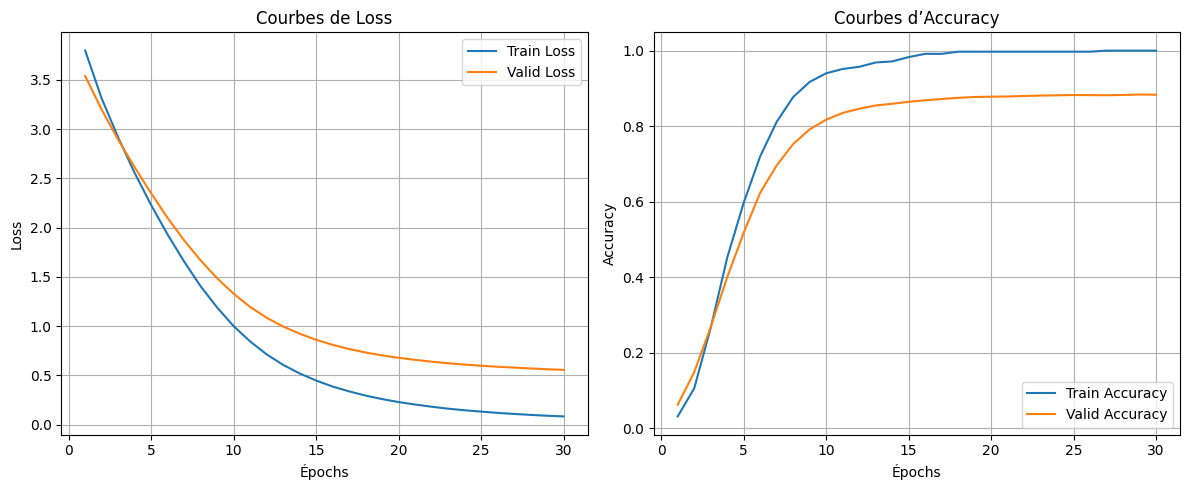

In [21]:
# Dans une même figure, tracer les courbes de loss Train et Valid dans un subplot et celles d'accuracy dans un autre subplot.
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Subplot des pertes
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Valid Loss')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.title('Courbes de Loss')
plt.legend()
plt.grid(True)

# Subplot des accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, valid_accs, label='Valid Accuracy')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.title('Courbes d’Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Calculer l'accuracy ou taux de bonne classification sur les jeux de **Train**, **Valid** et **Test**.

In [22]:
# Fonction pour s'assurer que les labels sont bien des tensors
def ensure_tensor(y):
    return y if isinstance(y, torch.Tensor) else torch.from_numpy(y).long()

# Conversion des jeux de données
y_train_tensor = ensure_tensor(y_train)
y_valid_tensor = ensure_tensor(y_valid)
y_test_tensor = ensure_tensor(y_test)

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid_pca, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)

# Fonction d'évaluation
def evaluate_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        predicted = torch.argmax(outputs, dim=1)
        correct = (predicted == y).sum().item()
        accuracy = correct / y.size(0)
    return accuracy, predicted

# Évaluation
acc_train, pred_train = evaluate_accuracy(model, X_train_tensor, y_train_tensor)
acc_valid, pred_valid = evaluate_accuracy(model, X_valid_tensor, y_valid_tensor)
acc_test, pred_test = evaluate_accuracy(model, X_test_tensor, y_test_tensor)

# Affichage des accuracies
print(f" Accuracy Train : {acc_train:.4f}")
print(f" Accuracy Valid : {acc_valid:.4f}")
print(f" Accuracy Test  : {acc_test:.4f}")


 Accuracy Train : 1.0000
 Accuracy Valid : 0.8832
 Accuracy Test  : 0.8698


## Questions Partie 2 : répondre sous chaque question.

- Combien d'epochs ont-elles été effectuées ?

- Quels taux de bonne classification obtenez-vous sur **Train**, **Valid** et **Test** ?

- Comparer avec la performance obtenue à la Partie 1, commenter.

- Remarquez-vous du sur-apprentissage ? Pourquoi ?

- Proposer une idée pour lutter contre le sur-apprentissage qui pourrait s'appliquer ici. Il n'est pas demandé de le faire pour ce rendu.

### Questions Partie 2 : répondre sous chaque question.

**1. Combien d'epochs ont-elles été effectuées ?**  
→ Le nombre d'epochs effectuées est de **30** (défini dans la fonction `for epoch in range(30):` car on le limite  ).

---

**2. Quels taux de bonne classification obtenez-vous sur Train, Valid et Test ?**  
→ Voici les résultats observés :  
- Accuracy **Train** : **1.0000**  
- Accuracy **Valid** : **0.8832**  
- Accuracy **Test** : **0.8698**

---

**3. Comparer avec la performance obtenue à la Partie 1, commenter.**  
→ Par rapport à la Partie 1, les performances sur les jeux de validation et test sont **très bonnes**.  
L’ACP a permis de réduire la dimension tout en conservant une bonne qualité de prédiction.  
Cependant, l’accuracy de 1.0 sur le jeu d'entraînement indique que le modèle a **potentiellement sur-appris** les données de Train, ce qui n’était peut-être pas aussi marqué dans la Partie 1.

---

**4. Remarquez-vous du sur-apprentissage ? Pourquoi ?**  
→ Oui, il y a du sur-apprentissage.  
Le modèle atteint une accuracy parfaite (1.0) sur l’entraînement, mais chute légèrement sur la validation (0.8832) et encore un peu plus sur le test (0.8698), ce qui suggère qu’il a appris à mémoriser les données de Train au lieu de généraliser.

---

**5. Proposer une idée pour lutter contre le sur-apprentissage qui pourrait s'appliquer ici. Il n'est pas demandé de le faire pour ce rendu.**  
→ Pour limiter le sur-apprentissage, on pourrait :  
- **Ajouter du dropout** dans le MLP.  
- **Utiliser de l’early stopping** basé sur la validation.  
- **Réduire la taille ou la complexité du modèle**.  
- **Appliquer de la régularisation L2** (weight decay).  
- **Augmenter la taille du dataset** si possible.
